<a href="https://colab.research.google.com/github/shivgarg/autoencoders/blob/master/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
from skimage import io
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import MNIST, CocoCaptions
from torchvision.utils import save_image
import time

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#!tar xzf /content/drive/My\ Drive/DL_Seminar/dev.tar.gz

In [0]:
#!tar xzf /content/drive/My\ Drive/DL_Seminar/train.tar.gz
!unzip -q /content/drive/My\ Drive/DL_Seminar/combined.zip

In [0]:
!ls /content/combined | wc -l

37500


In [0]:
img_transform = transforms.Compose([transforms.ToTensor()])

class Dataset(Dataset):
    def __init__(self, dirpath):
        self.path_list = [os.path.join(dirpath, x) for x in os.listdir(dirpath)]

    def __len__(self):
        return len(self.path_list)

    def __getitem__(self, index):

        # Load data and get label
        path = self.path_list[index]
        X = np.array(Image.open(path)).astype(np.float32)/255
        if(len(X.shape)!=3):
          X = np.repeat(X[:, :, np.newaxis], 3, axis=2)
        y = -1
  

        return img_transform(X), y
      
train_params = {'batch_size': 32,
                'shuffle': True,
                'num_workers': 8}
training_set = Dataset('/content/combined')

# validation_set = Dataset([i for i in range(30000, 36500)])
# validation_generator = data.DataLoader(validation_set, **params)

# for i in training_generator:
#   print(i[0])
#   break

In [0]:
def encoder_block():
        return nn.Sequential(nn.Conv2d(16, 16, 3, stride=1, padding=1),
                             nn.BatchNorm2d(16),
                             nn.ReLU(True),
                             nn.Conv2d(16, 16, 3, stride=1, padding=1),
                             nn.BatchNorm2d(16),
                             nn.ReLU(True))
def encoder_reduce(x):
        return nn.Sequential(nn.Conv2d(16, x, 3, stride=2, padding=1),
                             nn.BatchNorm2d(x),
                             nn.ReLU(True))
  
def decoder_block():
        return nn.Sequential(
            nn.Conv2d(16, 16, 3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 16, 3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True))

def decoder_expand():
        return nn.Sequential(nn.ConvTranspose2d(16,16, 3, stride=2,padding=1, output_padding=1),
                             nn.BatchNorm2d(16),
                             nn.ReLU(True))
  
class encoder(nn.Module):
    def __init__(self):
        super(encoder, self).__init__()
        self.encoder_start = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=1, padding=1),  # b, 16, 10, 10
            nn.BatchNorm2d(16),
            nn.ReLU(True))
        self.reduce_0 = encoder_reduce(16)
        self.encoder_1 = encoder_block()
        self.reduce_1 = encoder_reduce(16)
        self.encoder_2 = encoder_block()
        self.reduce_2 = encoder_reduce(16)
        self.encoder_3 = encoder_block()
        self.reduce_3 = encoder_reduce(8)
        
    def forward(self, x):
        out = self.encoder_start(x)
        out1 = self.reduce_0(out)
        out2 = self.encoder_1(out1)
        out3 = out2 + out1
        out4 = self.reduce_1(out3)
        out5 = self.encoder_2(out4)
        out6 = out4 + out5
        out7 = self.reduce_2(out6)
        out8 = self.encoder_3(out7)
        out9 = out7 +out8
        out10 = self.reduce_3(out9)
        return [out10, out1, out4, out7]


class decoder(nn.Module):
    def __init__(self):
        super(decoder, self).__init__()
        self.decoder_start = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2,padding=1, output_padding=1),  # b, 16, 5, 5
            #nn.BatchNorm2d(16),
            nn.ReLU(True))
        self.decoder_1 = decoder_block()
        self.expand_1 = decoder_expand()
        self.decoder_2 = decoder_block()
        self.expand_2 = decoder_expand()
        self.decoder_3 = decoder_block()
        self.expand_3 = decoder_expand()
        self.decoder_end = nn.Sequential(nn.Conv2d(16, 3, 3, stride=1, padding=1), nn.ReLU(True))

    def forward(self,x):
        out11 = self.decoder_start(x)
        out12 = self.decoder_1(out11)
        out13 = out12 + out11
        out14 = self.expand_1(out13)
        out15 = self.decoder_2(out14)
        out16 = out15 + out14
        out17 = self.expand_2(out16)
        out18 = self.decoder_3(out17)
        out19 = out18 + out17
        out20 = self.expand_3(out19)
        return [self.decoder_end(out20), out19, out16, out13] 

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


time:523.67 epoch [1/200], train_loss_l1:0.0988


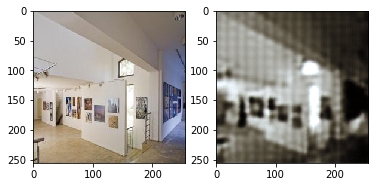

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


time:1045.71 epoch [2/200], train_loss_l1:0.0857


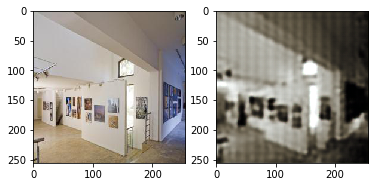

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


time:1567.89 epoch [3/200], train_loss_l1:0.0835


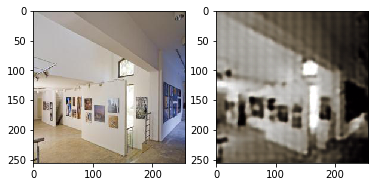

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


time:2089.95 epoch [4/200], train_loss_l1:0.0786


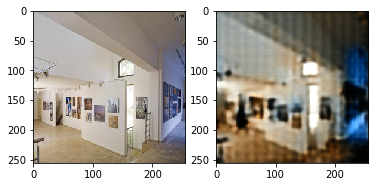

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


time:2611.84 epoch [5/200], train_loss_l1:0.0675


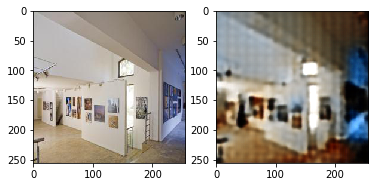

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


time:3133.33 epoch [6/200], train_loss_l1:0.0659


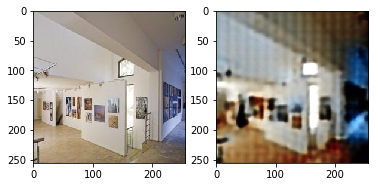

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


time:3654.82 epoch [7/200], train_loss_l1:0.0655


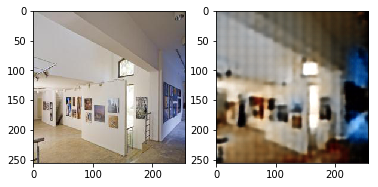

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


time:4176.03 epoch [8/200], train_loss_l1:0.0643


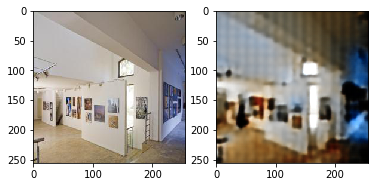

In [0]:
learning_rate = 1e-3
num_epochs = 200

training_generator = DataLoader(training_set, **train_params)


en = encoder().cuda()
dc = decoder().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    list(en.parameters())+list(dc.parameters()), lr=learning_rate, weight_decay=1e-5)


begin_time = time.time()
train_l1_epoch = []

for epoch in range(num_epochs):
    train_loss_l1_list = list()
    for data in training_generator:
        img, _ = data
        img = Variable(img).cuda()
        # ===================forward=====================
        [output, out1, out3, out5] = en(img)
        [output, out2, out4, out6] = dc(output)
        #output = dc(en(img))
        loss_l1 = torch.mean(torch.abs(output - img))# + torch.mean(torch.abs(out4-out3))/16 #+ torch.mean(torch.abs(out2-out1))/2 + torch.mean(torch.abs(out6-out5))/8 
        #loss_l2 = criterion(output, img)
        loss = loss_l1# + loss_l2
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_l1_list.append(loss_l1.item())
    torch.save(en.state_dict, "encoder_epoch_{}".format(epoch))
    torch.save(en.state_dict, "decoder_epoch_{}".format(epoch))
#validation
    train_loss_l1 = np.mean(train_loss_l1_list)
    #train_loss_l2 = np.mean(train_loss_l2_list)
    train_l1_epoch.append(train_loss_l1)
    #train_l2_epoch.append(train_loss_l2)
    end_time = time.time()
    elapsed_time = end_time - begin_time
    # ===================log========================
    print('time:{:.2f} epoch [{}/{}], train_loss_l1:{:.4f}'
          .format(elapsed_time, epoch + 1, num_epochs, train_loss_l1))
    
    train_img = training_set[0][0]
    train_img = np.moveaxis(np.array(train_img),0,-1)
    train_img1 = dc(en(training_set[0][0].unsqueeze(0).cuda())[0])[0]
    train_img1 = np.moveaxis(train_img1.cpu().detach().numpy(),0,-1).reshape(3,256,256)
    train_img1 = np.moveaxis(np.array(train_img1),0,-1)
    
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(train_img)
    axarr[1].imshow(train_img1)
    plt.show()
    
    